In [213]:
import os
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import missingno as msno
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
warnings.filterwarnings('ignore')

# 1. Data load

> Movielens 1M Dataset이 저장된 'ratings.dat' 데이터를 CSV 형식으로 불러온 후, 데이터의 내용을 정렬한 뒤 확인한다.

In [135]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


> 불러온 데이터를 확인한 결과 아래와 같은 정보를 획득했다.<br>
> 1. UserID(사용자), itemID(시청한 영화), Rating(별점), Time(시청시간) 으로, 총 4가지 정보를 가지고 있다.<br>
> 2. 영화 데이터는 총 1,000,209개 이다

# 2. Data EDA

> 모델 구성을 위해 데이터를 목적에 맞게 가공할 수 있도록, 데이터의 형태를 분석하는 과정을 진행한다.

## 2.1 Check missing values

> 불러온 데이터에 결측치가 있는지 확인하는 작업을 수행한다.

<AxesSubplot:>

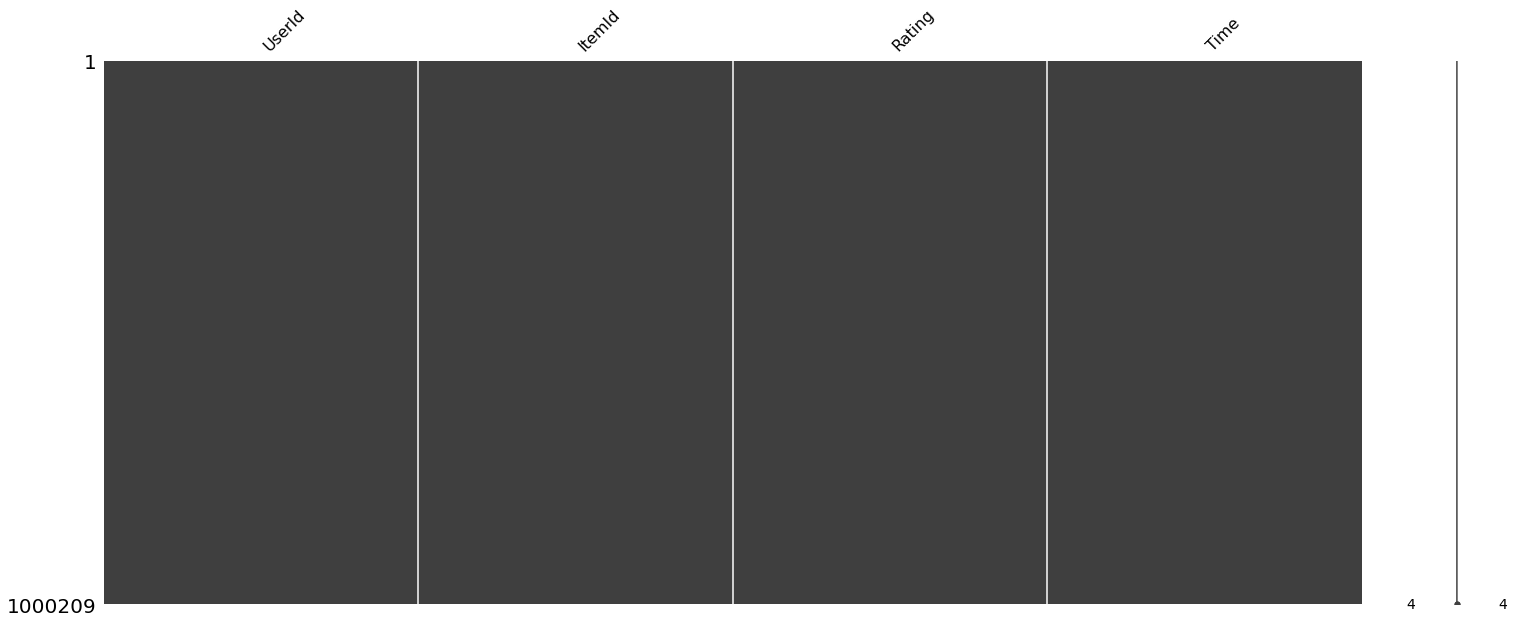

In [136]:
msno.matrix(data)

<AxesSubplot:>

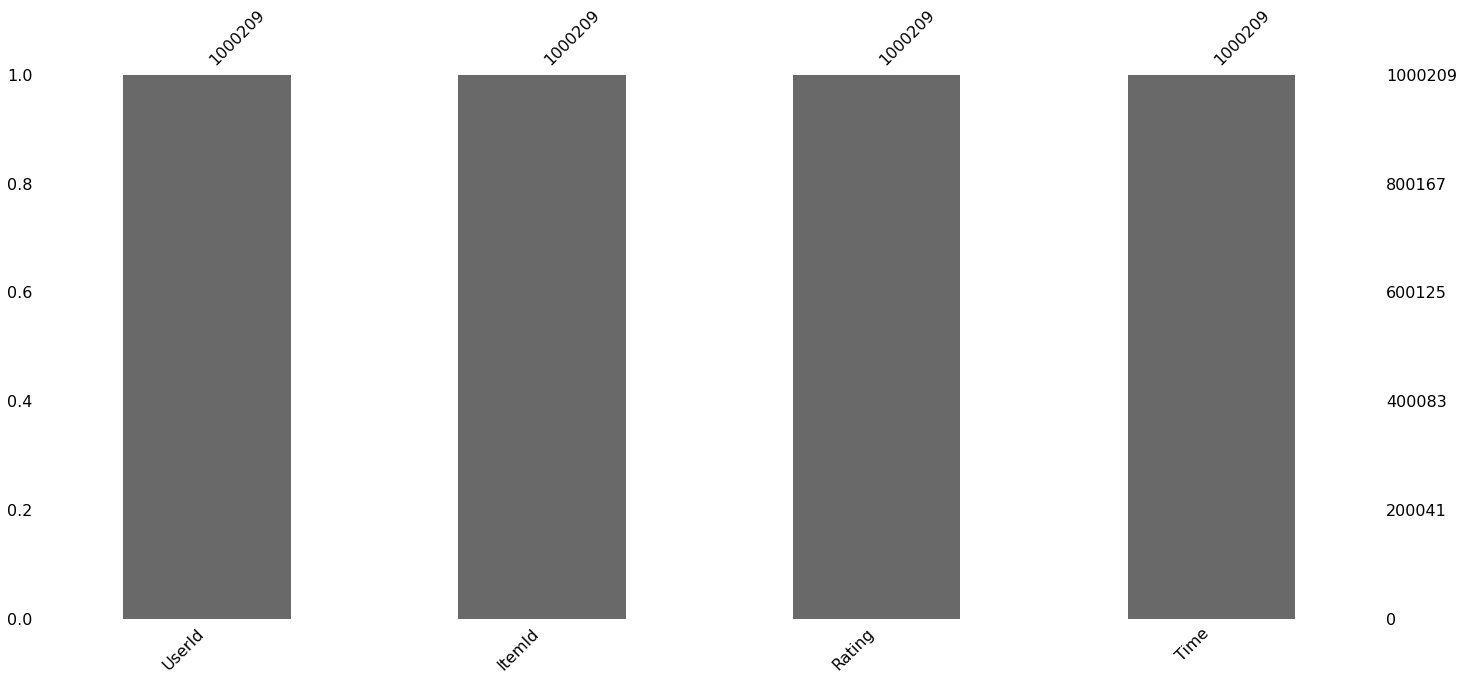

In [137]:
msno.bar(data)

> 영화 데이터를 시각적, 수치적 분석을 진행한 결과 결측치가 확인되지 않았다.

## 2.2 고유 유저와 영화 수

In [138]:
print('고유 유저 수 :', data['UserId'].nunique())
print('고유 영화 개수 :', data['ItemId'].nunique())

고유 유저 수 : 6040
고유 영화 개수 : 3706


> 1,000,209개 데이터 중 고유한 유저는 6040명이며, 영화는 3706개임을 확인할 수 있다.

## 2.3 각 유저의 영화 시청 횟수

In [139]:
UserId_length = data.groupby('UserId').size()
UserId_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

> 6040명의 유저마다 영화를 시청한 횟수 데이터를 확보했다.<br>
> 위 데이터를 활용하여 영화 시청 평균, 최소치, 최대치 등을 분석하는 과정을 진행한다.

In [140]:
print('영화 시청 횟수 평균 :', UserId_length.mean())
print('영화 시청 횟수 중앙값 :', UserId_length.median())
print('영화 시청 횟수 최소치 :', UserId_length.min())
print('영화 시청 횟수 최대치 :', UserId_length.max())
print('영화 시청 횟수 분위수 :', UserId_length.quantile(0.9))
print('영화 시청 횟수 분위수 :', UserId_length.quantile(0.99))

영화 시청 횟수 평균 : 165.5975165562914
영화 시청 횟수 중앙값 : 96.0
영화 시청 횟수 최소치 : 20
영화 시청 횟수 최대치 : 2314
영화 시청 횟수 분위수 : 400.0
영화 시청 횟수 분위수 : 906.659999999998


> 6040명의 유저 중 90%는 영화 시청수가 400회 이하이다.<br>
> 시청횟수가 400회를 초과하는 유저는 영화를 좋아하는 마니아일 가능성이 높다.(상위 10%)<br>
> 시청횟수가 906회를 초과하는 유저는 영화를 매우 좋아하는 진성 마니아일 가능성이 높다.(상위 1%)

## 2.4 각 영화별 상영된 횟수

In [141]:
ItemId_length = data.groupby('ItemId').size()
ItemId_length

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

In [142]:
print('상영된 영화의 평균 :', ItemId_length.mean())
print('상영된 영화의 중앙값 :', ItemId_length.median())
print('상영된 영화의 최소치 :', ItemId_length.min())
print('상영된 영화의 최대치 :', ItemId_length.max())
print('상영된 영화의 분위수 :', ItemId_length.quantile(0.9))
print('상영된 영화의 분위수 :', ItemId_length.quantile(0.99))

상영된 영화의 평균 : 269.88909875876953
상영된 영화의 중앙값 : 123.5
상영된 영화의 최소치 : 1
상영된 영화의 최대치 : 3428
상영된 영화의 분위수 : 729.5
상영된 영화의 분위수 : 1784.8999999999996


> 3706개의 영화 중 90%는 상영된 횟수가 729회 이하이다.<br>
> 상영 횟수가 729회를 초과하는 영화는 인기가 많았던 영화일 가능성이 높다.(상위 10%)<br>
> 상영 횟수가 1784회를 초과하는 영화는 국민 영화급으로 매우 인기가 많았던 영화일 가능성이 높다.(상위 1%)

## 2.5 평균 사용자의 분포 분석 및 시각화

> 우리의 목적은 대다수 사람들에게 영화를 추천할 모델을 만드는것이 목적이다.<br>
> 때문에 상위 1%의 데이터는 제외하고 나머지 99%의 유저 데이터를 사용하고자 한다.<br>
> 99%의 유저 데이터의 분포 누적합을 확인하는 작업을 진행한다.

In [143]:
length_count = UserId_length.groupby(UserId_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.99]
length_percent_cumsum_99

20     0.014238
21     0.029305
22     0.042053
23     0.055464
24     0.068874
         ...   
888    0.989073
893    0.989404
894    0.989570
900    0.989735
903    0.989901
Length: 684, dtype: float64

> 위 결과를 시각화하면 아래와 같다.

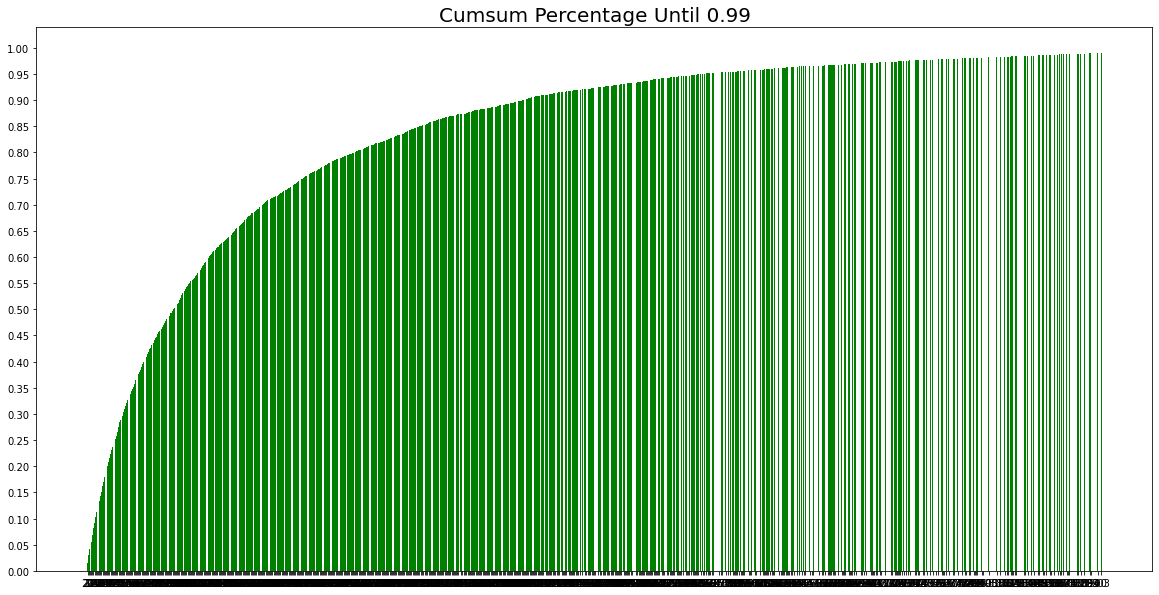

In [144]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='green')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

## 2.6 영화 시청 시간

> 유저가 영화를 시청하는 시간을 분석함으로써, 어떤 시간에 주로 영화를 시청하는지 확인하는 작업을 진행한다.

### 2.6.1 데이터의 시간 범위

> 데이터셋에 저장된 시간 데이터의 범위를 확인함으로써, 추천 조건에 활용할 시간 범위를 연구하는 작업을 진행한다.

In [145]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest//60//60//24//365) 
print(latest//60//60//24//365)

30
33


> 영화 시청 데이터의 최소시간과 최대시간을 년 단위로 분석한 결과 3년간의 데이터임을 확인할 수 있다.<br>
> 영화의 트렌드는 1달을 주기로 변화하므로, 최종 데이터로부터 30일 이내 시청 영화 데이터만 사용하고자 한다.

In [146]:
month_ago = latest - 2592000
month_ago_data = data[data['Time'] > month_ago]
month_ago_data

,UserId,ItemId,Rating,Time
28225,195,2808,3,1044220118
27759,195,1254,4,1044552222
27921,195,1456,2,1044662852
28443,195,468,3,1044985356
28255,195,2748,1,1044987808
...,...,...,...,...
984731,5950,3948,4,1046369637
984682,5950,3578,4,1046369670
984475,5950,3793,3,1046369710
984660,5950,3555,2,1046369737


> 30일 이내 데이터만 추출하니 100만개 데이터 중 1,551개 데이터를 확보했다.<br>
> 이 데이터는 모델이 학습하기에는 너무 적은 데이터 이다.<br>
> 이에, 추출할 데이터를 6개월 이내로 범위를 늘려서 재 추출하는 작업을 진행한다.

In [147]:
six_month_ago = latest - 15552000
six_month_ago_data = data[data['Time'] > six_month_ago]
six_month_ago_data

,UserId,ItemId,Rating,Time
5200,36,2269,5,1040544350
5256,36,1701,4,1040544350
5184,36,2694,3,1040544494
5364,36,3786,4,1040544521
5262,36,2369,4,1040544564
...,...,...,...,...
984733,5950,1262,4,1046369858
986778,5956,469,3,1033358097
992702,5996,168,3,1031058746
992459,5996,339,4,1033997079


> 6개월 이내를 기준으로 추출하니 100만개의 데이터 중 8823개가 추출되었다.<br>
> 모델이 유의미한 학습하기에는 적은 데이터이므로 1년 이내로 추출 범위를 확장하여 재추출하는 작업을 진행했다<br>

In [148]:
year_ago = latest - 31536000
year_ago_data = data[data['Time'] > year_ago]
year_ago_data

,UserId,ItemId,Rating,Time
5170,36,1387,5,1015904819
5267,36,1201,4,1015904819
5122,36,1291,5,1015904836
5123,36,2167,5,1015904905
5290,36,2951,4,1015904905
...,...,...,...,...
992358,5996,3835,3,1020113184
992279,5996,2422,3,1020113225
992702,5996,168,3,1031058746
992459,5996,339,4,1033997079


> 1년 이내 데이터를 추출하니 100만개 데이터 중 21.704개의 데이터를 확보했다.<br>
> 데이터의 총량은 아쉬우나, 모델이 유의미한 학습을 하기에는 충분한 데이터 갯수라 생각하여 더이상의 추출 작업은 진행하지 않는다.<br>
> (그러면, 98만개 데이터는 2~3년전 데이터에 있다는건데..?)

# 3. Data preprocessing

## 3.1 Delete low data

> 위 EDA 과정에서, 유저와 영화 데이터의 분포를 확인했다.<br>
> 각 데이터에서 너무 낮은 값은 추천 시스템에서 무의미한 정보이므로 이를 제거하는 작업을 진행한다.

In [149]:
# 조건 내 무의미한 최소치 데이터 제거 기능 함수
def cleanse_recursive(data: pd.DataFrame, low_play, movie_scene_count) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_user(data, low_play)
        data = cleanse_unpopular_item(data, movie_scene_count)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

# 유저 데이터 가공 함수
def cleanse_short_user(data: pd.DataFrame, low_play):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= low_play].index
    data = data[data['UserId'].isin(user_use)]
    return data

# 영화 데이터 가공 함수
def cleanse_unpopular_item(data: pd.DataFrame, movie_scene_count):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= movie_scene_count].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [150]:
proseccing_data = cleanse_recursive(year_ago_data, low_play=30, movie_scene_count=4)
proseccing_data

,UserId,ItemId,Rating,Time
5170,36,1387,5,1015904819
5267,36,1201,4,1015904819
5122,36,1291,5,1015904836
5123,36,2167,5,1015904905
5290,36,2951,4,1015904905
...,...,...,...,...
992358,5996,3835,3,1020113184
992279,5996,2422,3,1020113225
992702,5996,168,3,1031058746
992459,5996,339,4,1033997079


> 유저의 중위 시청횟수는 96이고, 최소값은 20이다.<br>
> 영화의 중위 상영횟수는 123회이고, 최소값은 1이다.<br>
> 위 정보를 바탕으로 여러 조건으로 데이터를 탐색하고 추출하는 작업을 진행한 결과를 다음과 같다.

|시청횟수/상영횟수 최소치|2회|3회|4회|5회|6회|
|---|---|---|---|---|---|
|20회|19,299개|18,385개|17,353개|16,181개|14,938개|
|30회|17,820개|16,917개|15,786개|14,334개|12,937개|
|40회|16,483개|15,522개|14,218개|12,654개|11,209개|
|50회|15,203개|14,040개|12,577개|10,945개|8,698개|

> 25가지 조건 실험을 통해, 위와 같은 결과를 얻을 수 있었다.<br>
> 유저의 시청횟수가 30회 이하 AND 영화 상영횟수 4회 이하인 데이터를 제거한 데이터셋이 추천 시스템 모델에 적합할 것이라 생각했다.

## 3.2 Create Train/valid/test dataset

> 데이터셋에서 훈련용, 검증용, 테스트용 데이터 세트를 생성하는 작업을 진행한다.<br>
> 현 데이터 셋은 1년 이내의 정보를 가지고 있다.<br>
> 이에, 훈련용 데이터는 12~3개월 이전 데이터를 사용한다.(10개월 치)<br>
> 검증용 데이터는 2개월 이내 AND 1개월 전 전 데이터를 사용한다.(1개월 치)<br>
> 테스트용 데이터는 1개월 이내 데이터를 사용한다.(1개월 치)

In [155]:
def split_by_date(data: pd.DataFrame, day: int):
    n_seconds = day*86400
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max()
    user_in_train = user_last_time[user_last_time < final_time - n_seconds].index
    user_in_test = user_last_time[user_last_time >= final_time - n_seconds].index

    before_date = data[data['UserId'].isin(user_in_train)]
    after_date = data[data['UserId'].isin(user_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [158]:
tr, test = split_by_date(proseccing_data, day=30)
tr, val = split_by_date(tr, day=30)

> 전처리 작업이 잘 수행되었는 확인하기 위해 시각화 작업을 진행한다

In [162]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t 데이터 개수: {len(data)}\n'
          f'\t 고유 유저 수: {data["UserId"].nunique()}\n'
          f'\t 고유 영화 개수: {data["ItemId"].nunique()}\n'
          f'\t 최초 시간 : {data["Time"].min()}\n'
          f'\t 마지막 시간 : {data["Time"].max()}\n')

In [163]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 데이터 개수: 8007
	 고유 유저 수: 98
	 고유 영화 개수: 1585
	 최초 시간 : 1014961419
	 마지막 시간 : 1041088491

* valid Set Stats Info
	 데이터 개수: 1903
	 고유 유저 수: 28
	 고유 영화 개수: 1039
	 최초 시간 : 1015266336
	 마지막 시간 : 1043799175

* test Set Stats Info
	 데이터 개수: 5824
	 고유 유저 수: 59
	 고유 영화 개수: 1558
	 최초 시간 : 1014955410
	 마지막 시간 : 1046454590



> 1년 이내 데이터셋이 훈련용/검증용/테스트용 데이터 셋으로 잘 분리되었음을 확인 할 수 있다.

## 3.3 Indexing

> 훈련용 데이터세트에 없는 영화가 검증용, 테스트용 데이터셋에 있을 수 있으므로 훈련용 데이터셋을 기준으로 인덱싱 작업을 진행한다

In [165]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

> 인덱싱이 완료된 데이터 셋은 백업하여 저장한다.

In [166]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 4. Data pipeline

> 이번 장은 미니 배치 구성을 위한 작업을 기술한 장이다.<br>
> GRU4ERC 논문에 기술된 Session-Parallel Mini-Batch 기법을 활용하여 학습 속도의 저하를 최소화 하고자 한다.<br>

## 4.1 Create UserID Dataset

> 데이터가 주어지면 유저의 ID가 시작되는 인덱스를 저장하는 변수와 유저 ID을 새로 인덱싱 후 저장한 변수를 갖는 클래스 생성한다.<br>
> 이는, 기존 무분별하게 생성된 Index를 일관성 있게 재생성 하여 편의성을 증대하기 위함이다.

In [175]:
class UserID_Dataset:
    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())

    def get_click_offsets(self):
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

> 훈련용 데이터 셋트의 유저 ID의 index를 재생성하는 작업을 수행한다.

In [176]:
tr_dataset = UserID_Dataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,1015904819,0
5267,36,1201,4,1015904819,1
5122,36,1291,5,1015904836,2
5123,36,2167,5,1015904905,3
5290,36,2951,4,1015904905,4
5359,36,2115,5,1015904905,5
5073,36,1912,5,1015904924,6
5113,36,2662,3,1015904924,7
5366,36,2985,4,1015904941,8
5145,36,198,5,1015904988,9


### 4.1.1 기존 index와 재생성 index 비교

In [170]:
tr_dataset.click_offsets

array([   0,   30,   79,  147,  230,  266,  304,  413,  462,  606,  651,
        692,  733,  787,  906, 1036, 1553, 1585, 1629, 1665, 1699, 1799,
       1836, 1886, 1997, 2057, 2125, 2356, 2386, 2452, 2623, 2726, 2784,
       2816, 2854, 2942, 2973, 3039, 3102, 3203, 3241, 3271, 3334, 3384,
       3528, 3592, 3674, 3916, 3993, 4061, 4160, 4294, 4324, 4382, 4431,
       4498, 4533, 4583, 4707, 4738, 4825, 4882, 4937, 4974, 5058, 5261,
       5373, 5404, 5434, 5492, 5572, 5728, 5766, 5805, 5848, 6124, 6165,
       6195, 6350, 6412, 6504, 6684, 6742, 6957, 7116, 7147, 7188, 7277,
       7307, 7354, 7387, 7472, 7509, 7597, 7675, 7751, 7845, 7891, 8007],
      dtype=int32)

> 위 값은 기존 고유 유저(98명) ID의 index 값이다. index가 일관되지 않고 제각각임을 확인 할 수 있다.

In [177]:
tr_dataset.user_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97])

> 위 값은 고유 유저 수(98명)에 알맞게 새로 인덱싱 되었음을 확인할 수 있다.

## 4.2 Create UserID data loader

> UserID_dataset을 입력받아, Session-Parallel mini-batch를 생성하는 클래스 구현한다. 

In [179]:
class UserID_DataLoader:
    def __init__(self, dataset: UserID_Dataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        start, end, mask, last_user, finished = self.initialize()

        while not finished:
            min_len = (end - start).min() - 1
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_user, finished = self.update_status(start, end, min_len, last_user, finished)

    def initialize(self):
        
        # step1. 첫 배치에 사용할 세션 Index load
        first_iters = np.arange(self.batch_size)
        
        # step2. last UserID Index 저장
        last_user = self.batch_size - 1
        
        # step3. dataset에서 UserId의 시작 위치 load
        start = self.dataset.click_offsets[self.dataset.user_idx[first_iters]]
        
        # step4. UserID가 끝난 위치의 next location load
        end = self.dataset.click_offsets[self.dataset.user_idx[first_iters] + 1]
        
        # step5. UserID가 시청한 모든 영화를 처리한 후 mask에 추가 예정
        mask = np.array([])
        
        # step6. dataset을 모두 탐색 및 처리 여부 기록
        finished = False
        
        return start, end, mask, last_user, finished
    
    # 다음 배치 데이터를 생성하기 위해 상태를 update하는 함수
    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_user: int, finished: bool):  
        
        # step1. __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 add
        start += min_len
        
        # step2. end는 다음 세션이 시작되는 위치이다. start와 한 칸 차이난다는 것은 UserID가 끝났음을 의미.
        # 따라서, mask에 기록한다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  

        # step3. mask에 추가된 유저 개수만큼 새로운 userID를 반복한다
        for i, idx in enumerate(mask, start=1):
            new_user = last_user + i
            
            # [IF] if( new UserID > last UserID index) ==> 모든 학습용 데이터셋 탐색 완료.
            if new_user > self.dataset.user_idx[-1]:
                finished = True
                break
                
            # step4. 다음 시작점/종료지점 업데이트
            start[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user]]
            end[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user] + 1]
            
        # 마지막 UserID 위치 기록
        last_user += len(mask)
        
        return start, end, mask, last_user, finished

> 이전 3장 데이터 전처리 과정에서 영화 최소 시청수를 5회 이상으로 설정했으므로 배치 사이즈도 5로 설정한다.

In [185]:
tr_data_loader = UserID_DataLoader(tr_dataset, batch_size=5)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,1015904819,0
5267,36,1201,4,1015904819,1
5122,36,1291,5,1015904836,2
5123,36,2167,5,1015904905,3
5290,36,2951,4,1015904905,4
5359,36,2115,5,1015904905,5
5073,36,1912,5,1015904924,6
5113,36,2662,3,1015904924,7
5366,36,2985,4,1015904941,8
5145,36,198,5,1015904988,9


> 배치 사이즈를 5로 설정했으므로, index도 5개가 출력될 것으로 예상된다.

In [186]:
iter_ex = iter(tr_data_loader)

In [187]:
inputs, labels, mask =  next(iter_ex)
print(f'모델에 입력될 영화 Index : {inputs}')
print(f'라벨의 영화 Index : {"":5} {labels}')
print(f'이전에 마스킹된 입력 index {mask}')

모델에 입력될 영화 Index : [ 0 30 60 72 13]
라벨의 영화 Index :       [ 1 31 58 77 54]
이전에 마스킹된 입력 index []


> 모델 입력값에 사용할 영화 index와 라벨 index의 구조와 값이 잘 설정되었음을 확인 할 수 있다.

# 5. Model design

## 5.1 모델 성능 지표 정의

> Session-Based Recommendation Task에서는 모델이 n개의 아이템을 제시했을 때, 유저가 시청한 영화가 m개가 많아야 좋다.<br>
> 이는 모델의 정확도 보다 복원율이 좋아야 함을 의미한다.<br>
> 이에, recall의 개념을 확장한 recall_k 지표와 순서에 민감한 지표인 MRR지표을 사용하고자 한다.

In [189]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 5.2  Model architecture

> RNN 모델 중 GRU 모델을 활용하여 학습 모델을 구성한다

In [191]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

> 모델에 사용할 hyper-parameter를 class형식으로 구성하여 편의성을 증대한다.

In [197]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_user = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

> RNN 계열 모델은 drop_out율이 높으면 학습 성능이 크게 떨어지므로 10%로 설정했다.<br>
> 훈련/검증/테스트용 dataset에서 고유 유저수 가장 수치가 28이다.<br>
> 때문에, 배치 사이즈도 28 이내로 설정한다. 그래야 index 범위 초과 오류를 방지할 수 있다.<br>

In [217]:
args = Args(tr, val, test, batch_size=28, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

> 위 과정의 하이퍼 파라미터로 설정한 모델을 생성한다.

In [218]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(28, 1, 1585)]           0         
_________________________________________________________________
GRU (GRU)                    [(28, 50), (28, 50)]      245550    
_________________________________________________________________
dropout_1 (Dropout)          (28, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (28, 1585)                80835     
Total params: 326,385
Trainable params: 326,385
Non-trainable params: 0
_________________________________________________________________


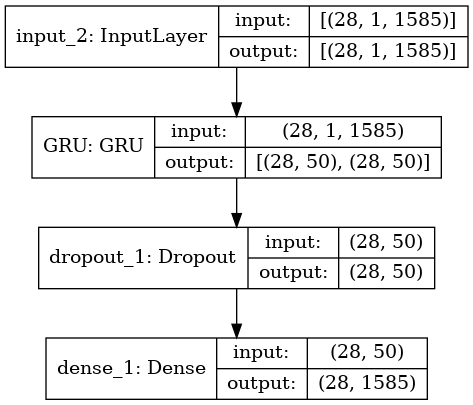

In [219]:
plot_model(model, show_shapes=True)

# 6. Model train

## 6.1 모델 학습 방법 기능 설계

> 훈련용 데이터세트를 활용하여 모델 학습 후 검증용/테스트용 데이터세트로 성능을 검증하는 함수를 구현한다.

In [215]:
def train_model(model, args):
    train_dataset = UserID_Dataset(args.tr)
    train_loader = UserID_DataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])
        
        # valid set 검증
        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    # step1. set gru layer from model
    gru_layer = model.get_layer(name='GRU')
    
    # step2. get marameter from gru_layer
    hidden_states = gru_layer.states[0].numpy()
    
    # step3. 종료된 UserID index값 반복하며 파라미터 초기화
    for elt in mask:
        hidden_states[elt, :] = 0
    gru_layer.reset_states(states=hidden_states)


# valid셋과 test셋을 평가하는 함수
def get_metrics(data, model, args, k: int):
    dataset = UserID_Dataset(data)
    loader = UserID_DataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 정렬

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    
    return recall, mrr

## 6.2 모델 학습 진행

> 학습에 사용될 모델의 하이퍼 파라미터는 다음과 같다.<br>
> Batch Size : 28<br>
> Drop_out Rate : 0.1<br>
> Learning Rate : 0.001<br>
> Epochs : 3<br>
> k : 20

In [220]:
train_model(model, args)

Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0, train_loss=6.95]     

	 - Recall@20 epoch 1: 0.051724
	 - MRR@20    epoch 1: 0.008351



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0, train_loss=6.96]     

	 - Recall@20 epoch 2: 0.045567
	 - MRR@20    epoch 2: 0.006433



Evaluation:  44%|████▍     | 29/66 [00:05<00:07,  5.11it/s]

	 - Recall@20 epoch 3: 0.049261
	 - MRR@20    epoch 3: 0.008034



> 정확도는 0%이며, 오류는 7점대가 나왔다.<br>
> loss의 감소율을 보니 학습이 안된것 같다.

# 7. Model test

> 학습된 모델을 활용하여 Recall, MRR 성능을 확인하는 함수를 구현 하고, 테스트 과정을 수행한다.

In [221]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [222]:
test_model(model, args, test)

Evaluation:  56%|█████▌    | 115/205 [00:22<00:17,  5.03it/s]

	 - Recall@20: 0.029814
	 - MRR@20: 0.005610



> 테스트 결과 Recall_K는 0.029, MRR은 0.005의 성능을 보여주었다.

> 위 과정에서 얻은 모델의 성능이 너무 낮아, 이를 개선하기 위한 연구를 진행한다.

# 8. 모델 개선 연구

## 8.1 하이퍼 파라미터 튜닝 실험

> 첫 모델의 성능을 개선하기 위해 하이퍼 파라미터를 변경했을때 성능을 측청하는 실험을 진행한다.

### 8.1.1 [E1 model] 학습율 변경

> 기존 모델은 학습율이 0.001로 설정되어 있었다.<br>
> 생각해보니, 1년 이내 데이터는 전체 데이터의 2%밖에 되지 않는, 매우 적은 데이터이다.<br>
> 따라서 학습율을 높여 가중치의 변화율에 가속을 주는 실험을 진행하고자 한다.<br>
> 이에, 학습율을 기존의 10배인 0.01로 설정하여 재 학습을 진행한다.

> E1 모델의 하이퍼 파라미터는 다음과 같다.<br>
> Batch Size : 28<br>
> Drop_out Rate : 0.1<br>
> Learning Rate : 0.01<br>
> Epochs : 3<br>
> k : 20

In [230]:
args = Args(tr, val, test, batch_size=28, hsz=50, drop_rate=0.1, lr=0.01, epochs=3, k=20)

In [231]:
e1_model = create_model(args)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(28, 1, 1585)]           0         
_________________________________________________________________
GRU (GRU)                    [(28, 50), (28, 50)]      245550    
_________________________________________________________________
dropout_4 (Dropout)          (28, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (28, 1585)                80835     
Total params: 326,385
Trainable params: 326,385
Non-trainable params: 0
_________________________________________________________________


In [228]:
train_model(e1_model, args)

Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0, train_loss=6.47]     

	 - Recall@20 epoch 1: 0.049261
	 - MRR@20    epoch 1: 0.010227



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.0357, train_loss=6.26]

	 - Recall@20 epoch 2: 0.040640
	 - MRR@20    epoch 2: 0.008912



Evaluation:  44%|████▍     | 29/66 [00:05<00:07,  5.14it/s]

	 - Recall@20 epoch 3: 0.040640
	 - MRR@20    epoch 3: 0.010117



In [229]:
test_model(e1_model, args, test)

Evaluation:  56%|█████▌    | 115/205 [00:22<00:17,  5.09it/s]

	 - Recall@20: 0.032919
	 - MRR@20: 0.010013



> 첫 모델 대비 Loss율이 큰 폭으로 줄어들었음을 확인할 수 있다. (기존: 7.3, 현재: 5.3)<br>
> 그래도 아직 정답율은 3%로 처참하며, loss도 매우 크다.<br>
> Racall_k은 이전 모델과 큰 차이가 없으나, MMR는 약 2배 증가한 모습을 보여주었다.<br>
> 그러나 절대적인 수치는 매우 낮다.<br><br>
> 이번 실험을 통해 모델의 학습율이 낮아 학습이 되어있지 않은 상태임을 확인했다

### 8.1.2 [E2 model] epoch 변경

> E1 model의 문제점을 개선하기 위해 기존의 epoch의 10배로 학습 횟수를 증가하여 학습한 모델을 생성하는 실험을 진행한다.

> E2 모델의 하이퍼 파라미터는 다음과 같다.<br>
> Batch Size : 28<br>
> Drop_out Rate : 0.1<br>
> Learning Rate : 0.01 (E1 모델의 learning_rate 차용)<br>
> Epochs : 30 (기존:3)<br>
> k : 20

In [236]:
args = Args(tr, val, test, batch_size=28, hsz=50, drop_rate=0.1, lr=0.01, epochs=30, k=20)

In [237]:
e2_model = create_model(args)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(28, 1, 1585)]           0         
_________________________________________________________________
GRU (GRU)                    [(28, 50), (28, 50)]      245550    
_________________________________________________________________
dropout_6 (Dropout)          (28, 50)                  0         
_________________________________________________________________
dense_6 (Dense)              (28, 1585)                80835     
Total params: 326,385
Trainable params: 326,385
Non-trainable params: 0
_________________________________________________________________


In [238]:
train_model(e2_model, args)

Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0, train_loss=6.54]     

	 - Recall@20 epoch 1: 0.046798
	 - MRR@20    epoch 1: 0.015309



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.0357, train_loss=6.4] 

	 - Recall@20 epoch 2: 0.027094
	 - MRR@20    epoch 2: 0.005860



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.107, train_loss=5.56] 

	 - Recall@20 epoch 3: 0.045567
	 - MRR@20    epoch 3: 0.012172



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.107, train_loss=4.29] 

	 - Recall@20 epoch 4: 0.043103
	 - MRR@20    epoch 4: 0.012441



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.286, train_loss=3.05]

	 - Recall@20 epoch 5: 0.043103
	 - MRR@20    epoch 5: 0.011818



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.571, train_loss=1.5] 

	 - Recall@20 epoch 6: 0.040640
	 - MRR@20    epoch 6: 0.011758



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.643, train_loss=1.67]

	 - Recall@20 epoch 7: 0.046798
	 - MRR@20    epoch 7: 0.014580



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.786, train_loss=1.07] 

	 - Recall@20 epoch 8: 0.040640
	 - MRR@20    epoch 8: 0.013157



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.607, train_loss=1.33] 

	 - Recall@20 epoch 9: 0.040640
	 - MRR@20    epoch 9: 0.015075



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.786, train_loss=0.856]

	 - Recall@20 epoch 10: 0.036946
	 - MRR@20    epoch 10: 0.014203



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.786, train_loss=0.784]

	 - Recall@20 epoch 11: 0.029557
	 - MRR@20    epoch 11: 0.011359



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.714, train_loss=0.791]

	 - Recall@20 epoch 12: 0.041872
	 - MRR@20    epoch 12: 0.015274



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.857, train_loss=0.593]

	 - Recall@20 epoch 13: 0.041872
	 - MRR@20    epoch 13: 0.012927



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.857, train_loss=0.784]

	 - Recall@20 epoch 14: 0.040640
	 - MRR@20    epoch 14: 0.014888



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.786, train_loss=0.774]

	 - Recall@20 epoch 15: 0.046798
	 - MRR@20    epoch 15: 0.015701



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.786, train_loss=0.544]

	 - Recall@20 epoch 16: 0.036946
	 - MRR@20    epoch 16: 0.014429



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.714, train_loss=0.814]

	 - Recall@20 epoch 17: 0.046798
	 - MRR@20    epoch 17: 0.014873



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.643, train_loss=1.11] 

	 - Recall@20 epoch 18: 0.041872
	 - MRR@20    epoch 18: 0.017676



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.857, train_loss=0.654]

	 - Recall@20 epoch 19: 0.044335
	 - MRR@20    epoch 19: 0.016217



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.893, train_loss=0.478]

	 - Recall@20 epoch 20: 0.035714
	 - MRR@20    epoch 20: 0.015791



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.857, train_loss=0.783]

	 - Recall@20 epoch 21: 0.039409
	 - MRR@20    epoch 21: 0.016307



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.821, train_loss=0.563]

	 - Recall@20 epoch 22: 0.043103
	 - MRR@20    epoch 22: 0.012696



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.893, train_loss=0.318]

	 - Recall@20 epoch 23: 0.043103
	 - MRR@20    epoch 23: 0.014422



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.679, train_loss=0.878]

	 - Recall@20 epoch 24: 0.044335
	 - MRR@20    epoch 24: 0.015148



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.821, train_loss=0.51] 

	 - Recall@20 epoch 25: 0.045567
	 - MRR@20    epoch 25: 0.015761



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.929, train_loss=0.269]

	 - Recall@20 epoch 26: 0.039409
	 - MRR@20    epoch 26: 0.013925



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.964, train_loss=0.248]

	 - Recall@20 epoch 27: 0.043103
	 - MRR@20    epoch 27: 0.014673



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.857, train_loss=0.594]

	 - Recall@20 epoch 28: 0.043103
	 - MRR@20    epoch 28: 0.013495



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.857, train_loss=0.448]

	 - Recall@20 epoch 29: 0.043103
	 - MRR@20    epoch 29: 0.014055



Evaluation:  44%|████▍     | 29/66 [00:05<00:07,  5.10it/s]

	 - Recall@20 epoch 30: 0.041872
	 - MRR@20    epoch 30: 0.011432



In [235]:
test_model(e2_model, args, test)

Evaluation:  56%|█████▌    | 115/205 [00:22<00:17,  5.04it/s]

	 - Recall@20: 0.034161
	 - MRR@20: 0.010801



> E1 모델 대비 정확도와 loss가 큰 폭으로 개선되었음을 확인할 수 있다.<br>
> 이전 3%의 정답율은 85%로 크게 증가했으며, loss도 기존 5.2에서 0.34로 크게 감소한 모습을 보여주었다.<br>
> 그러나 Racall_k과 MMR는 E1 모델 대비 변화가 미미했다.<br>
> 이번 실험을 통해 모델의 Epoch을 증가시킨것은 옳은 선택이였으나, Recall과 MMR 개선에는 효과적이지 못하다는 결론을 얻었다.

### 8.1.3 [E3 model] bacth size 변경

> E2 모델에서 학습 횟수를 증가하여 큰 성능의 비약을 보여주었으나 가장 중요한 성능 지표인 Recall, MMR의 성능은 매우 저조했다.<br>
> 이는 학습의 횟수 여부가 성능 향상 요인의 일부분이라는 의미이다.<br>
> 그래서 이번에는 batch size를 줄여 한 학습당 가중치의 변화 빈도를 높여 성능을 높이는 실험을 진행하고자 한다.<br>
> 이에, batch size를 기존의 28에서 8로 설정하여 약 4배의 가중치 변화 빈도를 증가시켜 재 학습을 진행한다.

> E3 모델의 하이퍼 파라미터는 다음과 같다.<br>
> Batch Size : 8 (기존: 28)<br>
> Drop_out Rate : 0.1<br>
> Learning Rate : 0.01 (E1 모델의 learning_rate 차용)<br>
> Epochs : 30 (E2 모델의 Epoch 차용)<br>
> k : 20

In [241]:
args = Args(tr, val, test, batch_size=8, hsz=50, drop_rate=0.1, lr=0.01, epochs=30, k=20)

In [242]:
e3_model = create_model(args)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(8, 1, 1585)]            0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        245550    
_________________________________________________________________
dropout_8 (Dropout)          (8, 50)                   0         
_________________________________________________________________
dense_8 (Dense)              (8, 1585)                 80835     
Total params: 326,385
Trainable params: 326,385
Non-trainable params: 0
_________________________________________________________________


In [243]:
train_model(e3_model, args)

Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0, train_loss=6.78]

	 - Recall@20 epoch 1: 0.046528
	 - MRR@20    epoch 1: 0.012101



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.125, train_loss=5]   

	 - Recall@20 epoch 2: 0.042361
	 - MRR@20    epoch 2: 0.013748



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0, train_loss=4.76]    

	 - Recall@20 epoch 3: 0.040278
	 - MRR@20    epoch 3: 0.011915



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.25, train_loss=3.7]  

	 - Recall@20 epoch 4: 0.040972
	 - MRR@20    epoch 4: 0.010694



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.375, train_loss=1.77]

	 - Recall@20 epoch 5: 0.042361
	 - MRR@20    epoch 5: 0.011315



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.92]

	 - Recall@20 epoch 6: 0.042361
	 - MRR@20    epoch 6: 0.010939



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.14]

	 - Recall@20 epoch 7: 0.050000
	 - MRR@20    epoch 7: 0.012862



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.17] 

	 - Recall@20 epoch 8: 0.042361
	 - MRR@20    epoch 8: 0.013030



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.23]

	 - Recall@20 epoch 9: 0.043750
	 - MRR@20    epoch 9: 0.012686



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.05]   

	 - Recall@20 epoch 10: 0.040278
	 - MRR@20    epoch 10: 0.013765



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.25, train_loss=1.94]  

	 - Recall@20 epoch 11: 0.041667
	 - MRR@20    epoch 11: 0.012910



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.835]

	 - Recall@20 epoch 12: 0.034722
	 - MRR@20    epoch 12: 0.009174



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.36]  

	 - Recall@20 epoch 13: 0.040278
	 - MRR@20    epoch 13: 0.010571



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.75, train_loss=1.36]  

	 - Recall@20 epoch 14: 0.042361
	 - MRR@20    epoch 14: 0.011473



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.5, train_loss=1.19]  

	 - Recall@20 epoch 15: 0.032639
	 - MRR@20    epoch 15: 0.011476



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.55] 

	 - Recall@20 epoch 16: 0.038194
	 - MRR@20    epoch 16: 0.010607



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.601]

	 - Recall@20 epoch 17: 0.040972
	 - MRR@20    epoch 17: 0.010576



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.375, train_loss=2.19] 

	 - Recall@20 epoch 18: 0.038194
	 - MRR@20    epoch 18: 0.012527



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.82] 

	 - Recall@20 epoch 19: 0.033333
	 - MRR@20    epoch 19: 0.011552



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.375, train_loss=3.61] 

	 - Recall@20 epoch 20: 0.031944
	 - MRR@20    epoch 20: 0.012595



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.875, train_loss=0.766]

	 - Recall@20 epoch 21: 0.039583
	 - MRR@20    epoch 21: 0.013439



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.5, train_loss=3.44]   

	 - Recall@20 epoch 22: 0.043056
	 - MRR@20    epoch 22: 0.010610



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.24]   

	 - Recall@20 epoch 23: 0.045139
	 - MRR@20    epoch 23: 0.011516



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.14]   

	 - Recall@20 epoch 24: 0.043056
	 - MRR@20    epoch 24: 0.013542



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.53] 

	 - Recall@20 epoch 25: 0.044444
	 - MRR@20    epoch 25: 0.012588



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.3]    

	 - Recall@20 epoch 26: 0.040278
	 - MRR@20    epoch 26: 0.013489



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.874] 

	 - Recall@20 epoch 27: 0.040972
	 - MRR@20    epoch 27: 0.012930



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.5, train_loss=2.42]   

	 - Recall@20 epoch 28: 0.042361
	 - MRR@20    epoch 28: 0.012898



Train:   0%|          | 0/988 [00:00<?, ?it/s, accuracy=0.625, train_loss=1.2]  

	 - Recall@20 epoch 29: 0.040278
	 - MRR@20    epoch 29: 0.011859



Evaluation:  77%|███████▋  | 180/234 [00:14<00:04, 12.07it/s]

	 - Recall@20 epoch 30: 0.037500
	 - MRR@20    epoch 30: 0.013206



In [244]:
test_model(e3_model, args, test)

Evaluation:  87%|████████▋ | 625/720 [00:52<00:07, 11.96it/s]

	 - Recall@20: 0.025200
	 - MRR@20: 0.007354



> E2 모델 대비 정확도와 loss의 지표가 오히려 나빠졌음을 확인할 수 있다.<br>
> 이전 85%의 정답율은 65%로 감소했으며, loss도 기존 0.34에서 0.91로 증가한 모습을 보여주었다.<br>
> Racall_k과 MMR는 E2 모델 대비 성능이 더 나빠졌다.<br>
> 이번 실험을 통해 모델의 batch size을 줄인것은 좋지 않다는 결론을 얻었다.

### 8.1.4 [E4 model] k 개수 변경

> E3 모델에서 이전 E2 모델보다 좋지 않는 성능을 보여주었다.<br>
> 이는 너무 작은 batch size을 설정하면 모델 훈련 시 1 배치 당 데이터 탐색의 범위가 너무 좁아 학습에 방해가 됨을 의미한다.<br>
> 이번에는, 학습 데이터가 적은 상황에서 너무 많은 영화를 추천하는게 부담이 되는것이 아닐까 싶어, 추천 개수를 줄여서 실험하고자 한다.<br>
> 이에, E2 모델을 기반으로 k를 기존의 20에서 10로 설정하여, 기존 대비 약 1/2개의 영화를 추론하도록 재 학습을 진행한다.

> E3 모델의 하이퍼 파라미터는 다음과 같다.<br>
> Batch Size : 28<br>
> Drop_out Rate : 0.1<br>
> Learning Rate : 0.01 (E1 모델의 learning_rate 차용)<br>
> Epochs : 30 (E2 모델의 Epoch 차용)<br>
> k : 10 (기존:20)

In [245]:
args = Args(tr, val, test, batch_size=28, hsz=50, drop_rate=0.1, lr=0.01, epochs=30, k=10)

In [246]:
e4_model = create_model(args)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(28, 1, 1585)]           0         
_________________________________________________________________
GRU (GRU)                    [(28, 50), (28, 50)]      245550    
_________________________________________________________________
dropout_9 (Dropout)          (28, 50)                  0         
_________________________________________________________________
dense_9 (Dense)              (28, 1585)                80835     
Total params: 326,385
Trainable params: 326,385
Non-trainable params: 0
_________________________________________________________________


In [247]:
train_model(e4_model, args)

Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0, train_loss=6.54]     

	 - Recall@10 epoch 1: 0.028325
	 - MRR@10    epoch 1: 0.008784



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0, train_loss=6.33]     

	 - Recall@10 epoch 2: 0.013547
	 - MRR@10    epoch 2: 0.004938



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.143, train_loss=5.14] 

	 - Recall@10 epoch 3: 0.022167
	 - MRR@10    epoch 3: 0.007167



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.214, train_loss=4.15] 

	 - Recall@10 epoch 4: 0.024631
	 - MRR@10    epoch 4: 0.006265



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.321, train_loss=2.35]

	 - Recall@10 epoch 5: 0.038177
	 - MRR@10    epoch 5: 0.011681



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.429, train_loss=2.35]

	 - Recall@10 epoch 6: 0.033251
	 - MRR@10    epoch 6: 0.011432



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.536, train_loss=1.88]

	 - Recall@10 epoch 7: 0.032020
	 - MRR@10    epoch 7: 0.010357



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.679, train_loss=1.28] 

	 - Recall@10 epoch 8: 0.035714
	 - MRR@10    epoch 8: 0.012490



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.857, train_loss=0.744]

	 - Recall@10 epoch 9: 0.032020
	 - MRR@10    epoch 9: 0.012065



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.643, train_loss=1.15] 

	 - Recall@10 epoch 10: 0.034483
	 - MRR@10    epoch 10: 0.013204



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.869] 

	 - Recall@10 epoch 11: 0.030788
	 - MRR@10    epoch 11: 0.011499



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.643, train_loss=1.3]  

	 - Recall@10 epoch 12: 0.032020
	 - MRR@10    epoch 12: 0.012532



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.786, train_loss=0.651]

	 - Recall@10 epoch 13: 0.025862
	 - MRR@10    epoch 13: 0.011971



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.747] 

	 - Recall@10 epoch 14: 0.033251
	 - MRR@10    epoch 14: 0.012467



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.863] 

	 - Recall@10 epoch 15: 0.024631
	 - MRR@10    epoch 15: 0.011367



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.857, train_loss=0.442]

	 - Recall@10 epoch 16: 0.029557
	 - MRR@10    epoch 16: 0.012409



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.857, train_loss=0.356]

	 - Recall@10 epoch 17: 0.027094
	 - MRR@10    epoch 17: 0.012537



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.75, train_loss=0.739] 

	 - Recall@10 epoch 18: 0.027094
	 - MRR@10    epoch 18: 0.010045



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.929, train_loss=0.32] 

	 - Recall@10 epoch 19: 0.023399
	 - MRR@10    epoch 19: 0.008234



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.714, train_loss=1.02] 

	 - Recall@10 epoch 20: 0.027094
	 - MRR@10    epoch 20: 0.009625



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.893, train_loss=0.498]

	 - Recall@10 epoch 21: 0.028325
	 - MRR@10    epoch 21: 0.010609



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.893, train_loss=0.269]

	 - Recall@10 epoch 22: 0.029557
	 - MRR@10    epoch 22: 0.013129



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.786, train_loss=0.583]

	 - Recall@10 epoch 23: 0.025862
	 - MRR@10    epoch 23: 0.009713



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=1, train_loss=0.187]    

	 - Recall@10 epoch 24: 0.023399
	 - MRR@10    epoch 24: 0.008210



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.893, train_loss=0.285]

	 - Recall@10 epoch 25: 0.023399
	 - MRR@10    epoch 25: 0.007687



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.929, train_loss=0.261]

	 - Recall@10 epoch 26: 0.024631
	 - MRR@10    epoch 26: 0.008870



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.786, train_loss=0.928]

	 - Recall@10 epoch 27: 0.024631
	 - MRR@10    epoch 27: 0.008745



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.929, train_loss=0.342]

	 - Recall@10 epoch 28: 0.024631
	 - MRR@10    epoch 28: 0.011574



Train:   0%|          | 0/282 [00:00<?, ?it/s, accuracy=0.857, train_loss=0.491]

	 - Recall@10 epoch 29: 0.022167
	 - MRR@10    epoch 29: 0.007408



Evaluation:  44%|████▍     | 29/66 [00:03<00:04,  7.88it/s]

	 - Recall@10 epoch 30: 0.024631
	 - MRR@10    epoch 30: 0.007568



In [249]:
test_model(e4_model, args, test)

Evaluation:  56%|█████▌    | 115/205 [00:23<00:18,  5.00it/s]

	 - Recall@10: 0.024845
	 - MRR@10: 0.007481



> E2 모델 대비 훈련 정확도는 약 4% 증가와 loss의 지표는 0.01이 개선된 모습을 확인할 수 있다.<br>
> E2 모델 대비 검증 정확도는 동일하며 val_loss은 0.5 나빠진 모습을 보여주었다..<br>
> Racall_k과 MMR는 E2 모델 대비 성능이 1/2로, 성능이 절반인 모습을 보여주었다.<br>
> 이번 실험을 통해 모델의 k을 줄인것은 훈련 성능 증가의 이점보다 성능 지표의 감소가 더 치명적이라는 결론을 얻었다.

> 지금까지 4번의 하이퍼 파라미터 튜닝으로 얻은 실험 결과는 아래 표와 같다.

|하이퍼 파라미터 / 모델명|원본 모델|E1 model|E2 model|E3 model|E4 model|
|---|---|---|---|---|---|
|drop_rate|10%|10%|10%|10%|10%|
|bacth_size|28|28|28|8|28|
|learning_rate|0.001|0.01|0.01|0.01|0.01|
|epoch|3|3|30|30|30|
|K|20|20|20|20|10|
|---|---|---|---|---|---|
|train_accuracy|0|3.57%|85.7%|62.5%|89.3%|
|train_loss|7.23|5.23|0.342|0.91|0.33|
|val_accuracy|0|3.57%|85.7%|62.5%|85.7%|
|val_loss|6.96|6.26|0.448|1.2|0.49|
|recall_k|0.029|0.032|0.041|0.025|0.02|
|MMR|0.005|0.010|0.011|0.007|0.007|

> 위 표를 통해 E2 모델이 가장 좋은 성능을 보여주었다.<br>
> 그러나, 필자는 문득 이런 생각이 들었다.<br>
> 지금까지 하이퍼 파라미터를 튜닝하면서, 적은 학습 데이터를 염두하며 실험을 진행했었고, 결과는 좋지 않았다.
> 그래서 이번에는 100만개의 데이터를 모두 사용해서 E2 모델의 하이퍼 파라미터를 기반으로 재학습을 진행하는 실험을 진행하고자 한다.

## 8.2 데이터 세트 변경

> 기존 모델들은 적은 학습 데이터량으로 인해 하이퍼 파라미터 튜닝으로는 성능을 향상함에 있어 한계가 있음을 확인하였다<br>
> 이에, 적은 학습량을 극복하고자, 기존 1년 이내의 데이터만 활용하지 않고 3년 간의 모든 데이터를 활용하여 모델을 구성하고자 한다.<br>
> 따라서, 이번 장에서는 3년치 전체 데이터를 전처리, 인덱싱, 모델 구성, 훈련하는 과정을 기술한다.

### 8.2.1 Data processing

### 8.2.1.1 Delete low data

> 전제 데이터에서 유저 당 최소 영화 시청횟수가 20회 이상이고, 영화 중 최저 상영 횟수가 1회이다.<br>
> 이에, 시청횟수가 50회 이하이고,상영횟수가 5회 이하인, 최소 값만 제거하는 과정을 진행한다.

In [283]:
all_data = cleanse_recursive(data, low_play=50, movie_scene_count=5)
all_data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


> 최소치만 제거했을때, 1,000,209 데이터 중 942,744개의 데이터가 추출되었다.<br>
> 기존 학습데이터 대비 약 48배이다

### 8.2.1.2 Create new train/valid/test dataset

> 전체 데이터로 데이터 세트를 구성할 경우 기존 시간 범위가 1년에서 3년으로, 3배가 증가한 범위이다.<br>
> 이에, 검증용 데이터와 테스트용 데이터의 시간 범위로 3배로 증가하여 구성한다.<br>
> 기존( 훈련용: 10개월, 검증용: 1개월, 테스트용 1개월, 총합 1년)<br>
> 신규( 훈련용: 28개월, 검증용: 3개월, 테스트용 3개월, 총합 3년)

In [284]:
all_tr, all_test = split_by_date(all_data, day=90)
all_tr, all_val = split_by_date(all_tr, day=90)

In [285]:
stats_info(all_tr, 'train')
stats_info(all_val, 'valid')
stats_info(all_test, 'test')

* train Set Stats Info
	 데이터 개수: 803619
	 고유 유저 수: 3961
	 고유 영화 개수: 3403
	 최초 시간 : 956703932
	 마지막 시간 : 1030826286

* valid Set Stats Info
	 데이터 개수: 41595
	 고유 유저 수: 104
	 고유 영화 개수: 3028
	 최초 시간 : 956853488
	 마지막 시간 : 1038664052

* test Set Stats Info
	 데이터 개수: 97530
	 고유 유저 수: 229
	 고유 영화 개수: 3274
	 최초 시간 : 957179713
	 마지막 시간 : 1046454590



> 3년 범위의 데이터셋이 훈련용/검증용/테스트용 데이터 셋으로 잘 분리되었음을 확인 할 수 있다.<br>
> 3개의 데이터 셋중 가장 적은 고유 유저가 104명이므로 모델에서 최대 설정 가능한 배치 사이즈는 104이다.

### 8.2.1.3 indexing

> 훈련용 데이터세트에 없는 영화가 검증용, 테스트용 데이터셋에 있을 수 있으므로 훈련용 데이터셋을 기준으로 인덱싱 작업을 진행한다

In [286]:
all_tr = indexing(all_tr, id2idx)
all_val = indexing(all_val, id2idx)
all_test = indexing(all_test, id2idx)

### 8.2.2 Create new UserID dataset

> 훈련용 전체데이터 셋에 무분별하게 생성되어있는 UserID의 Index를 일관성 있게 재생성 하는 작업을 수행한다.

In [287]:
all_tr_dataset = UserID_Dataset(all_tr)

In [288]:
all_tr_dataset.click_offsets

array([     0,     53,    182, ..., 803155, 803278, 803619], dtype=int32)

> 위와 같이  index가 무분별하게 기록되어 있음을 확인 할 수 있다.

In [289]:
all_tr_dataset.user_idx

array([   0,    1,    2, ..., 3958, 3959, 3960])

> 위와같이 고유 유저 수(3960명)에 알맞게 새로 인덱싱 되었음을 확인할 수 있다

### 8.2.3 Create new UserID data loader

> 이전 8.2.1.1장 에서 영화 최소 시청수를 6회 이상으로 설정했으므로 loder의 배치 사이즈도 5로 설정한다.

In [293]:
all_tr_data_loader = UserID_DataLoader(all_tr_dataset, batch_size=5)

> 배치 사이즈를 5로 설정했으므로, index도 5개가 출력될 것으로 예상된다.

In [296]:
all_iter_ex = iter(all_tr_data_loader)

In [308]:
all_inputs, all_labels, all_mask =  next(all_iter_ex)
print(f'모델에 입력될 영화 Index : {all_inputs}')
print(f'라벨의 영화 Index : {"":5} {all_labels}')
print(f'이전에 마스킹된 입력 index {all_mask}')

모델에 입력될 영화 Index : [317 419 770  71 784]
라벨의 영화 Index :       [612 952 546 105 690]
이전에 마스킹된 입력 index []


> 모델 입력값에 사용할 영화 index와 라벨 index의 구조와 값이 잘 설정되었음을 확인 할 수 있다.

### 8.2.4 Model design

> 전체 데이터를 활용하는 모델을 구성하고, 하이퍼 파라미터를 설정하는 과정을 기술한다.

In [301]:
args = Args(all_tr, all_val, all_test, batch_size=104, hsz=50, drop_rate=0.1, lr=0.05, epochs=30, k=20)

> all 모델의 하이퍼 파라미터는 배치 사이즈와 learning rate를 제외한 E2 모델의 하이퍼 파라미터와 같다.<br>
> 전체 데이터는 기존 대비 48배로, 매우 많으므로 학습율을 E2 대비 5배 상향하여 지정했다.
> Batch Size : 104<br>
> Drop_out Rate : 0.1<br>
> Learning Rate : 0.05 (기존: 0.01)<br>
> Epochs : 30 (E2 모델의 Epoch 차용)<br>
> k : 20

In [302]:
all_model = create_model(args)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(104, 1, 3403)]          0         
_________________________________________________________________
GRU (GRU)                    [(104, 50), (104, 50)]    518250    
_________________________________________________________________
dropout_17 (Dropout)         (104, 50)                 0         
_________________________________________________________________
dense_17 (Dense)             (104, 3403)               173553    
Total params: 691,803
Trainable params: 691,803
Non-trainable params: 0
_________________________________________________________________


In [303]:
train_model(all_model, args)

Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0673, train_loss=7.03]

	 - Recall@20 epoch 1: 0.172888
	 - MRR@20    epoch 1: 0.036138



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0962, train_loss=6.44]

	 - Recall@20 epoch 2: 0.168741
	 - MRR@20    epoch 2: 0.035022



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0481, train_loss=6.68]

	 - Recall@20 epoch 3: 0.188537
	 - MRR@20    epoch 3: 0.038550



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0577, train_loss=6.34]

	 - Recall@20 epoch 4: 0.182315
	 - MRR@20    epoch 4: 0.037672



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0481, train_loss=6.49]

	 - Recall@20 epoch 5: 0.189103
	 - MRR@20    epoch 5: 0.037444



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0385, train_loss=6.52]

	 - Recall@20 epoch 6: 0.179299
	 - MRR@20    epoch 6: 0.038640



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0385, train_loss=6.3] 

	 - Recall@20 epoch 7: 0.177225
	 - MRR@20    epoch 7: 0.035749



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0769, train_loss=5.93]

	 - Recall@20 epoch 8: 0.183069
	 - MRR@20    epoch 8: 0.040517



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0769, train_loss=6.51]

	 - Recall@20 epoch 9: 0.190422
	 - MRR@20    epoch 9: 0.040673



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0385, train_loss=6.66]

	 - Recall@20 epoch 10: 0.196456
	 - MRR@20    epoch 10: 0.043116



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0577, train_loss=6.67]

	 - Recall@20 epoch 11: 0.176659
	 - MRR@20    epoch 11: 0.038111



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0673, train_loss=6.32]

	 - Recall@20 epoch 12: 0.184578
	 - MRR@20    epoch 12: 0.039292



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0673, train_loss=6.37]

	 - Recall@20 epoch 13: 0.192685
	 - MRR@20    epoch 13: 0.042785



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0865, train_loss=6.19]

	 - Recall@20 epoch 14: 0.189668
	 - MRR@20    epoch 14: 0.039559



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0865, train_loss=6.46]

	 - Recall@20 epoch 15: 0.188160
	 - MRR@20    epoch 15: 0.040791



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0673, train_loss=6.73]

	 - Recall@20 epoch 16: 0.196833
	 - MRR@20    epoch 16: 0.043890



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0481, train_loss=6.48]

	 - Recall@20 epoch 17: 0.194382
	 - MRR@20    epoch 17: 0.042733



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0962, train_loss=6.37]

	 - Recall@20 epoch 18: 0.190234
	 - MRR@20    epoch 18: 0.041940



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0481, train_loss=6.6] 

	 - Recall@20 epoch 19: 0.187217
	 - MRR@20    epoch 19: 0.040774



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0673, train_loss=6.51]

	 - Recall@20 epoch 20: 0.180430
	 - MRR@20    epoch 20: 0.041981



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0288, train_loss=6.52]

	 - Recall@20 epoch 21: 0.189291
	 - MRR@20    epoch 21: 0.040180



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0673, train_loss=6.48]

	 - Recall@20 epoch 22: 0.189291
	 - MRR@20    epoch 22: 0.039329



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0385, train_loss=6.41]

	 - Recall@20 epoch 23: 0.190422
	 - MRR@20    epoch 23: 0.040918



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0673, train_loss=6.09]

	 - Recall@20 epoch 24: 0.194382
	 - MRR@20    epoch 24: 0.041079



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0673, train_loss=6.46]

	 - Recall@20 epoch 25: 0.180807
	 - MRR@20    epoch 25: 0.039245



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0577, train_loss=6.33]

	 - Recall@20 epoch 26: 0.176282
	 - MRR@20    epoch 26: 0.036883



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0673, train_loss=6.42]

	 - Recall@20 epoch 27: 0.176094
	 - MRR@20    epoch 27: 0.035618



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0673, train_loss=6.45]

	 - Recall@20 epoch 28: 0.171003
	 - MRR@20    epoch 28: 0.037709



Train:   0%|          | 0/7689 [00:00<?, ?it/s, accuracy=0.0577, train_loss=6.51]

	 - Recall@20 epoch 29: 0.186463
	 - MRR@20    epoch 29: 0.039048



Evaluation:  13%|█▎        | 51/398 [00:30<03:25,  1.69it/s]

	 - Recall@20 epoch 30: 0.191365
	 - MRR@20    epoch 30: 0.042991



In [306]:
test_model(all_model, args, all_test)

Evaluation:  68%|██████▊   | 634/935 [06:30<03:05,  1.62it/s]

	 - Recall@20: 0.114475
	 - MRR@20: 0.021298



> E2 모델 대비 훈련 정확도와 loss의 지표는 나쁜 모습을 보여주었다.(train_accuracy :85%->18%, train_loss : 0.38 -> 5.87) <br>
> E2 모델 대비 검증 정확도와 loss의 지표도 나쁜 모습을 보여주었다. (val_accuracy :85.7%-> 5.7%, val_loss : 0.0.44 -> 6.51) <br>
> Racall_k과 MMR는 E2 모델 대비 성능이 2배 이상 증가한 모습을 보여주었다.(recall_k :0.041-> 0.114, MMR : 0.011->0.021)<br>
> 이번 실험을 통해 이전 모델은 학습 데이터 량이 충분하지 못했음을 확인 할 수 있었다
> 이번 all 모델은 훈련/검증/테스트 결과는 E2 모델에 비해 낮았으나, 성능 지표인 recall과 MRR에서는 개선된 모습을 보여주었다.<br>
> 이는 학습 데이터 량에 비해 훈련 횟수가 부족하여 학습이 덜 되었기 때문이라고 생각한다.<br>
> 때문에, epoch 또는 learning rate를 높여주면 더 좋은 결과를 기대할 수 있으리라 생각한다.

> 지금까지 4번의 하이퍼 파라미터 튜닝과 데이터세트 변경으로 얻은 모든 실험 결과는 아래 표와 같다.

|하이퍼 파라미터 / 모델명|원본 모델|E1 model|E2 model|E3 model|E4 model|all model|
|---|---|---|---|---|---|---|
|drop_rate|10%|10%|10%|10%|10%|10%|
|bacth_size|28|28|28|8|28|104|
|learning_rate|0.001|0.01|0.01|0.01|0.01|0.05|
|epoch|3|3|30|30|30|30|
|K|20|20|20|20|10|20|
|---|---|---|---|---|---|---|
|train_accuracy|0|3.57%|85.7%|62.5%|89.3%|5.7%|
|train_loss|7.23|5.23|0.342|0.91|0.33|5.87|
|val_accuracy|0|3.57%|85.7%|62.5%|85.7%|5.7%
|val_loss|6.96|6.26|0.448|1.2|0.49|6.51|
|recall_k|0.029|0.032|0.041|0.025|0.02|0.114|
|MMR|0.005|0.010|0.011|0.007|0.007|0.021|

# 후기

> 이번 프로젝트는 학습에 사용할 데이터의 조건을 정하는것과 하이퍼 파라미터에 대해 많은 고민을 하게된 실습이었습니다.<br>
> 위 2장 데이터 분석의 기록와 같이,데이터셋의 데이터는 100만개 이나, 모델에 알맞은 조건 데이터는 2% 밖에 없었습니다.<br>
> 또한, 3장 데이터 전처리 과정에서도 추천 시스템에 적합한 조건에 맞는 데이터가 매우 적거나 아예 없기도 했습니다.<br>
> 위와같이 적은 데이터로 모델을 효과적으로 학습시키기 위해 다양한 가설을 세우고 실험을 했습니다.<br>
> 8장 모델 실험 장에서 하이퍼 파라미터 튜닝과 학습 데이터 량에 따른 성능의 변화의 폭이 큰 모습을 확인할 수 있었습니다.<br>
> 전체 데이터를 활용한 모델을 epoch 100회 정도 충분히 학습했을 때의 결과를 확인하지 못한것에 대한 아쉬움이 남습니다.